In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=16, color='k')
    
    delta = y_cvl-p_y_cvl
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=16, color='k')

    delta = y_tst-p_y_tst
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    sigma = np.std(delta[np.where(np.abs(delta)<0.5)])
    ax.text(x0,y0, 'RMS = '+'%.2f'%sigma, fontsize=16, color='k')

    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=16)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 


    fig.savefig(plotName+".png")
    plt.show()
#######################################

In [2]:
## loading data
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

Feature Importances:  [0.05099344 0.04152399 0.02666062 0.88082195]
g_r 	-->  5.10%
r_i 	-->  4.15%
i_z 	-->  2.67%
pc0 	-->  88.08%


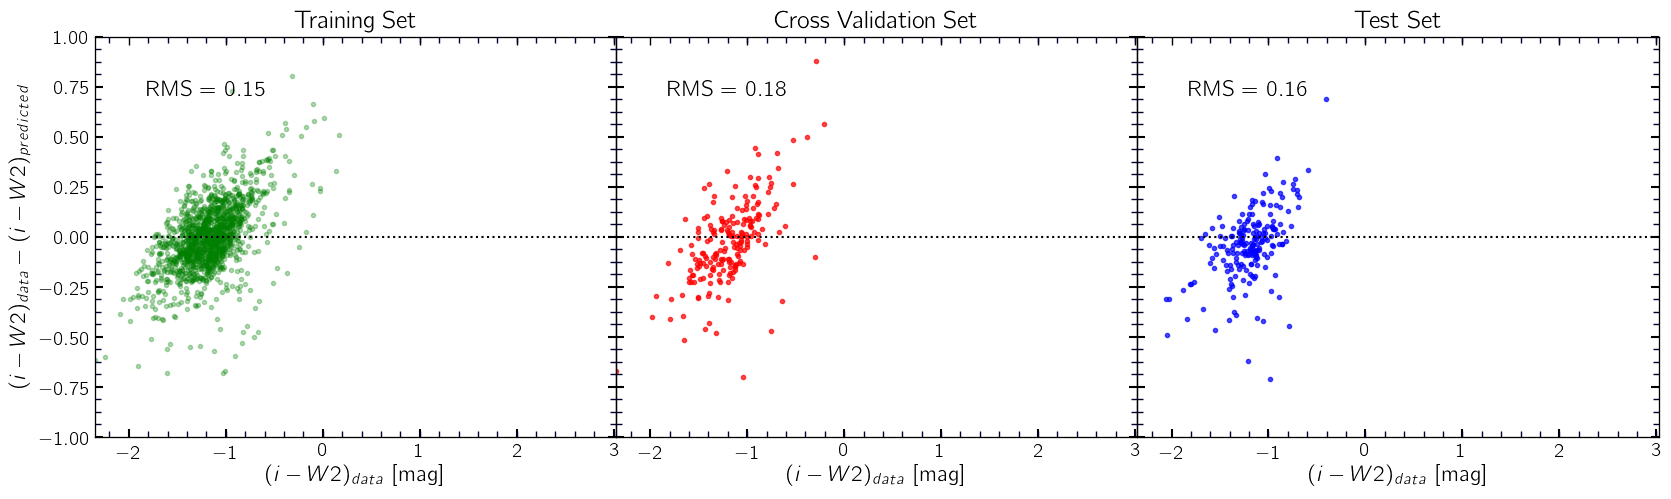

In [3]:
## Sample management
## table_tst: Test table
## table_cvl: Cross Validation table
## table_trn: Training Table
## N_test: Number of test data points
## N_cross: Number of cross validation data points
## Seed_test: Random seed number to choose the test sample (i.e. fixed=0)
## Seed_cross: Random seed number to choose the cross validation sample 
##                     (can be changed to see the algorithm performance)
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=200)
import pylab as py

################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'z_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=15
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i-W2'
text_unit = 'mag'
x0 = np.min(table_trn[output])
x1 = np.max(table_trn[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

200
200
1894


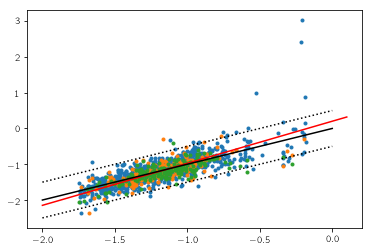

In [4]:
print len(table_tst['pgc'])
print len(table_cvl['pgc'])
print len(table["Wba"])

plt.plot(p_y_trn, y_trn, '.')
plt.plot(p_y_cvl, y_cvl, '.')
plt.plot(p_y_tst, y_tst, '.')
# plt.ylim(0,3)

d = np.abs(p_y_trn-y_trn)
tt = 0.5
indx, = np.where(d<tt)
X = p_y_trn[indx]
Y = y_trn[indx]
scaler = StandardScaler()
data = {'X':X, 'Y':Y}
order_of_keys = ['X','Y']
list_of_tuples = [(key, data[key]) for key in order_of_keys]
data = OrderedDict(list_of_tuples)
n_comp = len(data)
d =  pd.DataFrame.from_dict(data) 
z_data = scaler.fit_transform(d)
pca = PCA().fit(z_data)
u = scaler.mean_ ; ux=u[0]; uy=u[1]
s = scaler.scale_ ; sx=s[0]; sy=s[1]
x_ = np.linspace(-2,0.1,50)
pca_inv_data = pca.inverse_transform(np.eye(n_comp))
px = pca_inv_data[0,0]
py = pca_inv_data[0,1]
y_ = (py*sy*(x_-ux))/px/sx+uy
alpha = (py*sy)/px/sx
beta = (py*sy*(-ux))/px/sx+uy
plt.plot(x_, alpha*x_+beta, 'r-') 

plt.plot([-2,0], [-2,0], 'k-') 
plt.plot([-2,0], [-2+tt,0+tt], 'k:') 
plt.plot([-2,0], [-2-tt,0-tt], 'k:') 



0.1563863097085501
0.20739417855930717


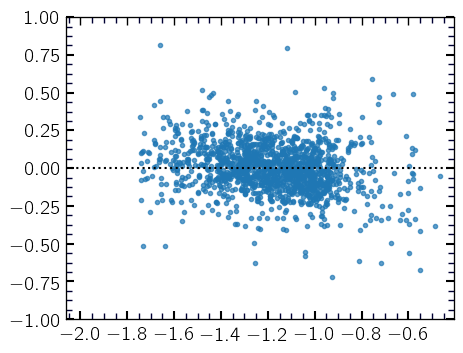

In [5]:
text     = 'i-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]

import pylab as py
fig = py.figure(figsize=(5, 4), dpi=100) 
ax = fig.add_subplot(111)

dd = y_trn-(alpha*p_y_trn+beta)

ax.plot(p_y_trn, dd, '.', alpha=0.7)

# ax.plot(y_trn, y_trn-(1.*p_y_trn+0.), 'r.', alpha=0.3)

print np.std(dd[np.where(np.abs(dd)<0.5)])
print np.std(dd)


ax.plot([-10,10],[0,0], 'k:')
set_axes([ax], xlim, ylim)

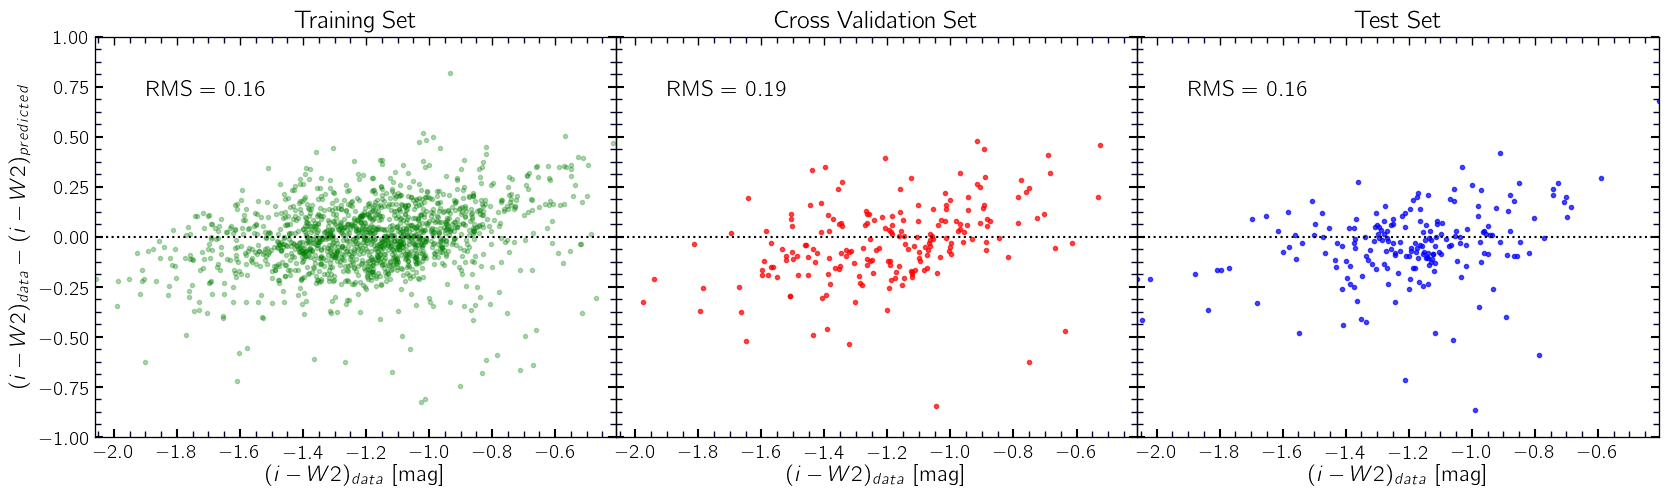

In [6]:
makePlot(x_trn, y_trn, alpha*p_y_trn+beta, x_cvl, y_cvl, alpha*p_y_cvl+beta, x_tst, y_tst, alpha*p_y_tst+beta, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

6654 78 0.995 13.749
62 13.743648856728583 [-5.5793159e-09]
Delta W: 0.01
2.1946734410138724e-05
2.3579884086466496e-05
2.9957371893207796e-05
3.7965020527608306e-05


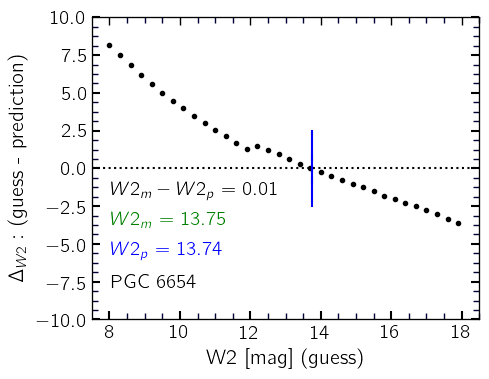

In [7]:
j = 80
PGC = table_tst['pgc'][j]
W2  = table_tst['w2'][j]
INC = table_tst["inc"][j]
P0  = table_tst["pc0"][j]
M21 = table_tst["m21"][j]
M0  = table_tst["logWimx"][j]
WBA = table_tst["Wba"][j]
R50 = table_tst["R50_w2"][j]
print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_tst, regr, features, output, index=j, alpha=alpha, beta=beta)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')


ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_ylim([-10,10])
xlim = ax.get_xlim()
ylim = ax.get_ylim()

set_axes([ax], xlim, ylim)


x0 = 0.95*xlim[0]+0.05*xlim[1]
y0 = 0.9*ylim[0]+0.1*ylim[1]
ax.text(x0,y0, 'PGC '+'%d'%PGC, fontsize=14, color='k')


ax.set_xlabel('W2 [mag] (guess)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (guess - prediction)', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    
    
    x0 = 0.95*xlim[0]+0.05*xlim[1]
    y0 = 0.6*ylim[0]+0.40*ylim[1]
    ax.text(x0,y0, r'$W2_m-W2_p$'+' = '+'%.2f'%(W2-w2p), fontsize=14, color='k')
    y0 = 0.7*ylim[0]+0.30*ylim[1]
    ax.text(x0,y0, r'$W2_m$'+' = '+'%.2f'%(W2), fontsize=14, color='green')
    y0 = 0.8*ylim[0]+0.20*ylim[1]
    ax.text(x0,y0, r'$W2_p$'+' = '+'%.2f'%w2p, fontsize=14, color='blue')    
    
    
    
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'b-') 


In [8]:
W2_lst = []
w2p_lst = []

for j in range(len(table_tst['pgc'])):
    
    PGC = table_tst['pgc'][j]
    W2  = table_tst['w2'][j]
    INC = table_tst["inc"][j]
    P0  = table_tst["pc0"][j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    WBA = table_tst["Wba"][j]
    R50 = table_tst["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_tst, regr, features, output, index=j, alpha=alpha, beta=beta)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst.append(W2)
        w2p_lst.append(w2p)
    ###############################################
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)

In [9]:
W2_lst0 = []
w2p_lst0 = []

for j in range(len(table_cvl['pgc'])):
    
    PGC = table_cvl['pgc'][j]
    W2  = table_cvl['w2'][j]
    INC = table_cvl["inc"][j]
    P0  = table_cvl["pc0"][j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_cvl, regr, features, output, index=j, alpha=alpha, beta=beta)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst0.append(W2)
        w2p_lst0.append(w2p)
    ###############################################
W2_lst0 = np.asarray(W2_lst0)
w2p_lst0 = np.asarray(w2p_lst0)

0.26385121315591964
0.24397905218909446


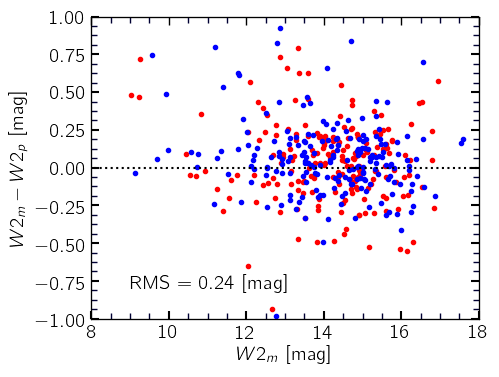

In [10]:
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(W2_lst0, W2_lst0-w2p_lst0, 'r.')
ax.plot(W2_lst, W2_lst-w2p_lst, 'b.')


ax.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [8,18], [-1,1])

W2_lst_ = np.concatenate((W2_lst0,W2_lst))
w2p_lst_ = np.concatenate((w2p_lst0,w2p_lst))

ax.text(9,-0.8, 'RMS = '+'%.2f'%np.std(W2_lst-w2p_lst)+' [mag]', fontsize=14, color='k')

print np.std(W2_lst0-w2p_lst0)
print np.std(W2_lst-w2p_lst)

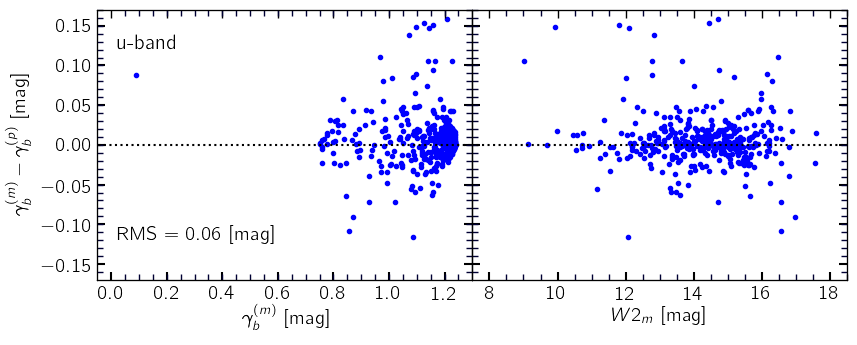

In [11]:
def getReddening(inc, pc0, band1='r', band2='w2'):
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
    
    if gamma<0:
        gamma=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    
    Aj = F*gamma
    
    return Aj, gamma
#################################################################
fig = py.figure(figsize=(10, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst0[j]
    w2m = W2_lst0[j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    INC = table_cvl["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='u', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='u', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='b')
ax_.plot(W2_lst0, gamma_m-gamma_p, '.', color='b')
d = gamma_m-gamma_p
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst[j]
    w2m = W2_lst[j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    WBA = table_tst["Wba"][j]
    R50 = table_tst["R50_w2"][j]
    INC = table_tst["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='u', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='u', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='b')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='b')
d = np.concatenate((d,gamma_m-gamma_p))
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%np.std(d)+' [mag]', fontsize=14, color='k')
#################################################################

    
    
ax.set_xlabel(r'$\gamma_b^{(m)}$'+' [mag]', fontsize=14)
ax_.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$\gamma_b^{(m)}-\gamma_b^{(p)}$'+' [mag]', fontsize=14)

ax.text(0.02,0.12, 'u-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
set_axes([ax], [-0.05,1.3], [-0.17,0.17])

set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

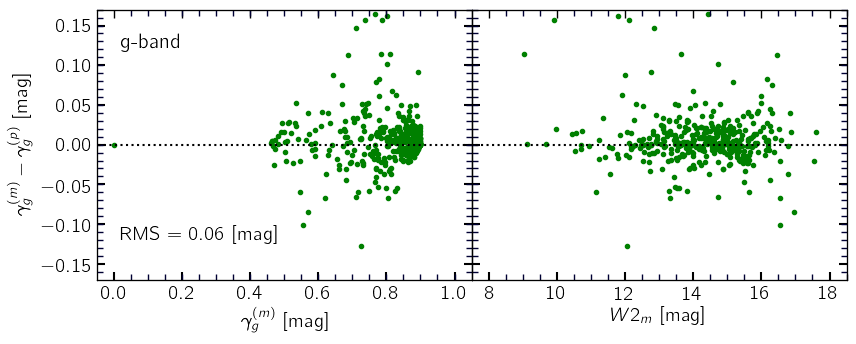

In [12]:
def getReddening(inc, pc0, band1='r', band2='w2'):
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
    
    if gamma<0:
        gamma=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    
    Aj = F*gamma
    
    return Aj, gamma
#################################################################
fig = py.figure(figsize=(10, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst0[j]
    w2m = W2_lst0[j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    INC = table_cvl["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='g', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='g', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='green')
ax_.plot(W2_lst0, gamma_m-gamma_p, '.', color='green')
d = gamma_m-gamma_p
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst[j]
    w2m = W2_lst[j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    WBA = table_tst["Wba"][j]
    R50 = table_tst["R50_w2"][j]
    INC = table_tst["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='g', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='g', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='green')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='green')
d = np.concatenate((d,gamma_m-gamma_p))
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%np.std(d)+' [mag]', fontsize=14, color='k')
#################################################################

    
    
ax.set_xlabel(r'$\gamma_g^{(m)}$'+' [mag]', fontsize=14)
ax_.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$\gamma_g^{(m)}-\gamma_g^{(p)}$'+' [mag]', fontsize=14)

ax.text(0.02,0.12, 'g-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
set_axes([ax], [-0.05,1.05], [-0.17,0.17])

set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

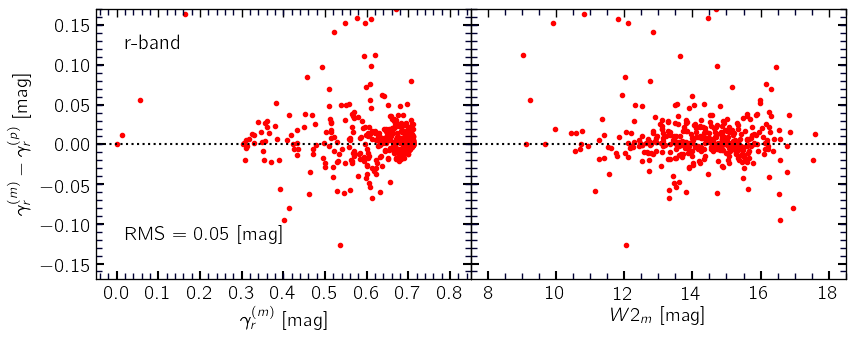

In [13]:
def getReddening(inc, pc0, band1='r', band2='w2'):
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
    
    if gamma<0:
        gamma=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    
    Aj = F*gamma
    
    return Aj, gamma
#################################################################
fig = py.figure(figsize=(10, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst0[j]
    w2m = W2_lst0[j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    INC = table_cvl["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='r', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='r', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='red')
ax_.plot(W2_lst0, gamma_m-gamma_p, '.', color='red')
d = gamma_m-gamma_p
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst[j]
    w2m = W2_lst[j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    WBA = table_tst["Wba"][j]
    R50 = table_tst["R50_w2"][j]
    INC = table_tst["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='r', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='r', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='red')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='red')
d = np.concatenate((d,gamma_m-gamma_p))
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%np.std(d)+' [mag]', fontsize=14, color='k')
#################################################################

    
    
ax.set_xlabel(r'$\gamma_r^{(m)}$'+' [mag]', fontsize=14)
ax_.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$\gamma_r^{(m)}-\gamma_r^{(p)}$'+' [mag]', fontsize=14)

ax.text(0.02,0.12, 'r-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
set_axes([ax], [-0.05,0.85], [-0.17,0.17])

set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

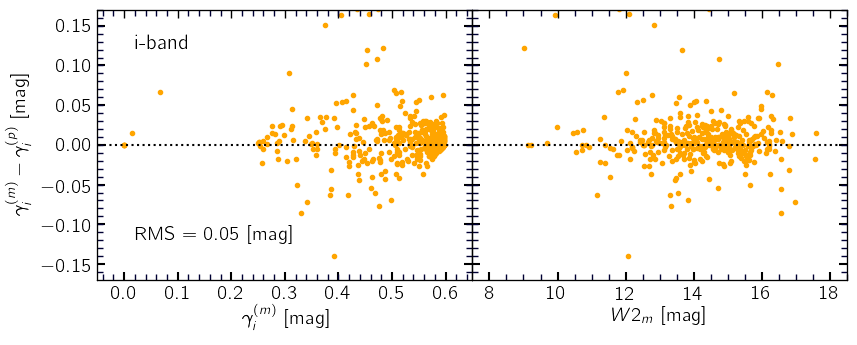

In [14]:
def getReddening(inc, pc0, band1='r', band2='w2'):
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
    
    if gamma<0:
        gamma=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    
    Aj = F*gamma
    
    return Aj, gamma
#################################################################
fig = py.figure(figsize=(10, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst0[j]
    w2m = W2_lst0[j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    INC = table_cvl["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='i', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='i', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orange')
ax_.plot(W2_lst0, gamma_m-gamma_p, '.', color='orange')
d = gamma_m-gamma_p
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst[j]
    w2m = W2_lst[j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    WBA = table_tst["Wba"][j]
    R50 = table_tst["R50_w2"][j]
    INC = table_tst["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='i', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='i', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orange')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='orange')
d = np.concatenate((d,gamma_m-gamma_p))
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%np.std(d)+' [mag]', fontsize=14, color='k')
#################################################################

    
    
ax.set_xlabel(r'$\gamma_i^{(m)}$'+' [mag]', fontsize=14)
ax_.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=14)

ax.text(0.02,0.12, 'i-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
set_axes([ax], [-0.05,0.65], [-0.17,0.17])

set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

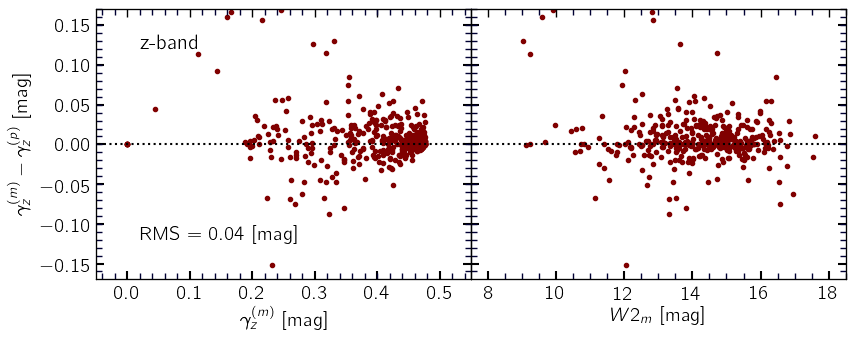

In [15]:
def getReddening(inc, pc0, band1='r', band2='w2'):
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
    
    if gamma<0:
        gamma=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    
    Aj = F*gamma
    
    return Aj, gamma
#################################################################
fig = py.figure(figsize=(10, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst0[j]
    w2m = W2_lst0[j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
    WBA = table_cvl["Wba"][j]
    R50 = table_cvl["R50_w2"][j]
    INC = table_cvl["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='z', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='z', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='maroon')
ax_.plot(W2_lst0, gamma_m-gamma_p, '.', color='maroon')
d = gamma_m-gamma_p
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
for j in range(N):
    
    w2p = w2p_lst[j]
    w2m = W2_lst[j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    WBA = table_tst["Wba"][j]
    R50 = table_tst["R50_w2"][j]
    INC = table_tst["inc"][j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='z', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='z', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='maroon')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='maroon')
d = np.concatenate((d,gamma_m-gamma_p))
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%np.std(d)+' [mag]', fontsize=14, color='k')
#################################################################

    
    
ax.set_xlabel(r'$\gamma_z^{(m)}$'+' [mag]', fontsize=14)
ax_.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$\gamma_z^{(m)}-\gamma_z^{(p)}$'+' [mag]', fontsize=14)

ax.text(0.02,0.12, 'z-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
set_axes([ax], [-0.05,0.55], [-0.17,0.17])

set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

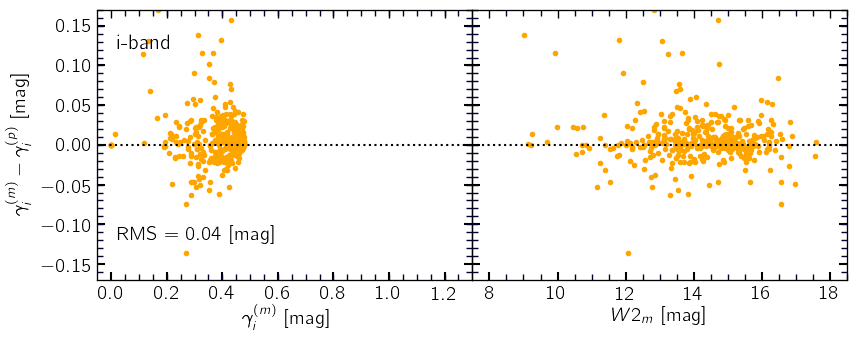

In [16]:
def halflight(reg, rer, rei, rez):
    m_g = 0.71 # slopes for halflight model
    m_r = 0.76
    m_i = 0.78
    m_z = 0.82

    b_g = 0.077 # y-intercepts for halflight model
    b_r = 0.072
    b_i = 0.069
    b_z = 0.068
    
    N = len(reg)

    W = np.ones(shape = (4,N))
    W[0] = reg
    W[1] = rer
    W[2] = rei
    W[3] = rez
    prox = np.median(W.T,1)

    W2 = np.zeros(N)     

    
    for ii in np.arange(N):
        
        if prox[ii] is None: prox[ii]=rez[ii]
        if prox[ii] is None: prox[ii]=rei[ii]
        if prox[ii] is None: prox[ii]=rer[ii]
        if prox[ii] is None: prox[ii]=reg[ii]
        if prox[ii] is None: prox[ii]=0
        
        if   np.abs(rez[ii]-prox[ii])<0.2: W2[ii] = m_z*rez[ii]+b_z
        elif np.abs(rei[ii]-prox[ii])<0.2: W2[ii] = m_i*rei[ii]+b_i
        elif np.abs(rer[ii]-prox[ii])<0.2: W2[ii] = m_r*rer[ii]+b_r
        elif np.abs(reg[ii]-prox[ii])<0.2: W2[ii] = m_g*reg[ii]+b_g
        else: W2[ii] = prox[ii]
    
    return W2
        

#################################################################
def ba(Sba):
    m_sba = 0.854 # slope for Wba vs Sba
    b_sba = 0.124 # y-intercept for Wba vs Sba
    return m_sba*Sba+b_sba
#################################################################
    
def getReddening(inc, pc0, band1='r', band2='w2'):
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
    
    if gamma<0:
        gamma=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    
    Aj = F*gamma
    
    return Aj, gamma
#################################################################
fig = py.figure(figsize=(10, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
R50_p = halflight(table_cvl["R50_g"], table_cvl["R50_r"], table_cvl["R50_i"], table_cvl["R50_z"])
for j in range(N):
    
    w2p = w2p_lst0[j]
    w2m = W2_lst0[j]
    M21 = table_cvl["m21"][j]
    M0  = table_cvl["logWimx"][j]
#     WBA = table_cvl["Wba"][j]
#     R50 = table_cvl["R50_w2"][j]
    INC = table_cvl["inc"][j]
    WBA = ba(table_cvl["Sba"][j])
    R50 = R50_p[j]
       
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='z', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='z', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orange')
ax_.plot(W2_lst0, gamma_m-gamma_p, '.', color='orange')
d = gamma_m-gamma_p
#################################################################
N = len(table_cvl['pgc'])
gamma_m = np.zeros(N)
gamma_p = np.zeros(N)
R50_p = halflight(table_tst["R50_g"], table_tst["R50_r"], table_tst["R50_i"], table_tst["R50_z"])
for j in range(N):
    
    w2p = w2p_lst[j]
    w2m = W2_lst[j]
    M21 = table_tst["m21"][j]
    M0  = table_tst["logWimx"][j]
    INC = table_tst["inc"][j]
    WBA = ba(table_tst["Sba"][j])
    R50 = R50_p[j]
    
    logWimx, c21w, mu50, P0 = get_PC(w2m, M21, M0, WBA, R50)
    _, gamma_m[j] = getReddening(INC, P0, band1='z', band2='w2')
    logWimx, c21w, mu50, P0 = get_PC(w2p, M21, M0, WBA, R50)
    _, gamma_p[j] = getReddening(INC, P0, band1='z', band2='w2')

ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orange')
ax_.plot(W2_lst, gamma_m-gamma_p, '.', color='orange')
d = np.concatenate((d,gamma_m-gamma_p))
ax.text(0.02,-0.12, 'RMS = '+'%.2f'%np.std(d)+' [mag]', fontsize=14, color='k')
#################################################################

    
    
ax.set_xlabel(r'$\gamma_i^{(m)}$'+' [mag]', fontsize=14)
ax_.set_xlabel(r'$W2_m$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=14)

ax.text(0.02,0.12, 'i-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([0,20],[0,0], 'k:')
set_axes([ax], [-0.05,1.3], [-0.17,0.17])

set_axes([ax_], [7.5,18.5], [-0.17,0.17])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)